In [2]:
import pandas as pd

import numpy as np

from numba import cuda

import pickle

import os

import cv2

from pycm import ConfusionMatrix

import time

import lwmw

import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Грузим данные 

1. Таблички

In [1]:
1 / 5

0.2

In [4]:
a = os.listdir("Dataset/Origin/")
b = os.listdir("Dataset/Expert/")
c = os.listdir("Dataset/sample_1/")
d = os.listdir("Dataset/sample_2/")
e = os.listdir("Dataset/sample_3/")

In [5]:
open_part = pd.read_csv("Dataset/OpenPart.csv")
shapes = pd.read_csv("Dataset/DX_TEST_RESULT_FULL.csv")

In [6]:
a = [x.split("_")[0] + "_" + x.split("_")[1].split(".")[0] for x in a]
b = [x.split("_")[0] + "_" + x.split("_")[1] for x in b]
c = [x.split("_")[0] + "_" + x.split("_")[1] for x in c]
e = [x.split("_")[0] + "_" + x.split("_")[1] for x in e]
f = [x.split("_")[0] + "_" + x.split("_")[1].split(".")[0] for x in list(open_part.Case.values)]

In [6]:
#проверка совпадения имен файлов
print(f"Соотносящихся элементов: {len(list(set(a) & set(b) & set(c) & set(e) & set(f)))}")

Соотносящихся элементов: 60


[]

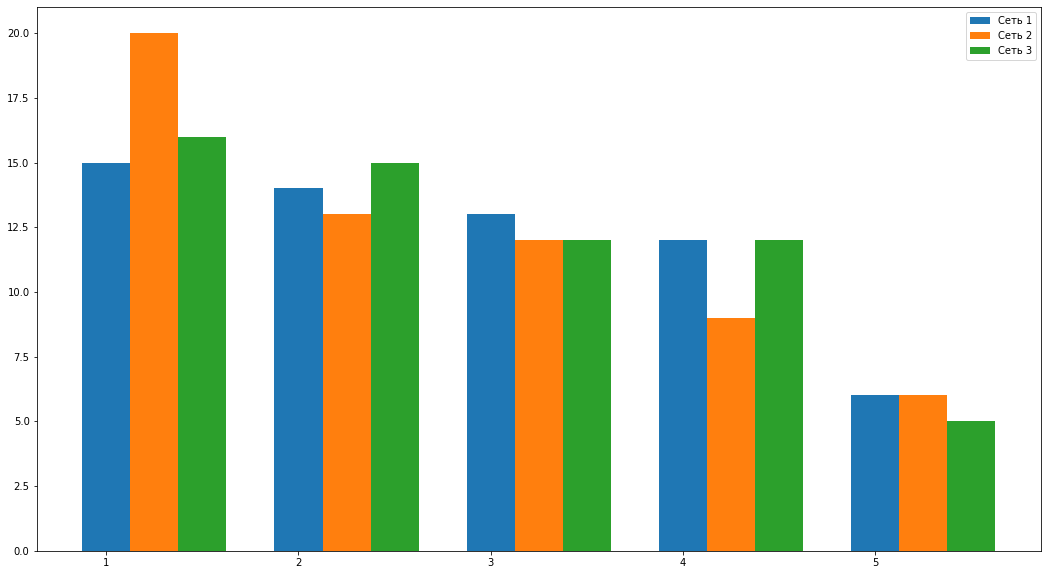

In [7]:
plt.figure(figsize=(18,10))
ind = np.arange(1, 6)
plt.bar(ind, open_part["Sample 1"].value_counts(), label="Сеть 1",  width = 0.25)
plt.bar(ind + 0.25, open_part["Sample 2"].value_counts(), label="Сеть 2",  width = 0.25)
plt.bar(ind + 0.50, open_part["Sample 3"].value_counts(), label="Сеть 3",  width = 0.25)
plt.legend(loc="upper right")
plt.plot()

2. Изображения

In [6]:
samples = {}

for sample in range(1,4):
    temp_names = os.listdir(f"Dataset/sample_{sample}/")
    img_buffer = []
    for img_name in temp_names:
        img_buffer.append(cv2.imread(f"Dataset/sample_{sample}/{img_name}") / 255.0)
    samples[f"sample_{sample}"] = img_buffer

In [7]:
print(len(samples["sample_1"]), len(samples["sample_2"]), len(samples["sample_3"]))

100 100 100


In [8]:
origin = []

temp_names = os.listdir(f"Dataset/Origin/")
for img_name in temp_names:
    origin.append(cv2.imread(f"Dataset/Origin/{img_name}") / 255.0)

In [9]:
print(len(origin))

100


In [10]:
expert = []

temp_names = os.listdir(f"Dataset/Expert/")
for img_name in temp_names:
    expert.append(cv2.imread(f"Dataset/Expert/{img_name}") / 255.0)
del temp_names

In [11]:
print(len(expert))

100


Сопоставляем имена и названия файлов

In [12]:
print("Проверка масок, Оригинальных изображений")
mismatch = 0

for sample in samples.keys():
    for img in range(len(samples[sample])):
        if samples[sample][img].shape != samples[sample][img].shape:
            mismatch += 1
            
for orig in range(len(origin)):
    if origin[orig].shape != origin[0].shape:
        mismatch += 1
    
for exp in range(len(expert)):
    if expert[exp].shape != expert[0].shape:
        mismatch += 1
    
print(f"Форма в разметке не совпадает в {mismatch} случаев")

Проверка масок, Оригинальных изображений
Форма в разметке не совпадает в 0 случаев


Проверка на "нулевые" картинки

In [13]:
clear = 0
for img in expert:
    if img.sum() == 0:
        clear += 1
print(f"Пустой разметки от эксперта {clear}")

Пустой разметки от эксперта 9


## == Считаем Метрики ==

In [14]:
def pixel_accuracy(nn, expert):
    return sum(nn * expert) / (sum(expert))

def Jaccard(nn, expert):
    return sum(nn * expert) / (sum(nn) + sum(expert) - sum(nn * expert))

def Sorensen(nn, expert):
    return (2 * sum(nn * expert)) / (sum(nn) + sum(expert))

def Kulchinski(nn, expert):
    return ((sum(nn * expert)) / 2) * (1 / sum(nn) + 1 / sum(expert))

def Simpson(nn, expert):
    return (2 * sum(nn * expert)) / (sum(nn) + sum(expert) - abs(sum(nn) - sum(expert)))

def Braun(nn, expert):
    return (2 * sum(nn * expert)) / (sum(nn) + sum(expert) + abs(sum(nn) - sum(expert)))

In [15]:
temp_names = os.listdir("Dataset/sample_1/")
metrics = pd.DataFrame()
for i in range(len(expert)):
    temp_overal = ConfusionMatrix(actual_vector=expert[i].ravel(),predict_vector=samples["sample_1"][i].ravel())
    temp_metrics = {  "name": temp_names[i],
                      "PA": pixel_accuracy(samples["sample_1"][i], expert[i]),
                      "Jaccard": Jaccard(samples["sample_1"][i], expert[i]),
                      "Sorensen": Sorensen(samples["sample_1"][i], expert[i]),
                      "Kulchinski": Kulchinski(samples["sample_1"][i], expert[i]),
                      "Simpson": Simpson(samples["sample_1"][i], expert[i]),
                      "Braun_Blanke": Braun(samples["sample_1"][i], expert[i])
                   }
    temp_overal = temp_overal.overall_stat
    for j in temp_overal.keys():
        temp_metrics[j] = temp_overal[j]
        
    metrics = metrics.append(temp_metrics, ignore_index=True)

/home/gpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/gpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/gpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/gpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [16]:
metrics = metrics.drop(columns=["95% CI", "P-Value", "Kappa 95% CI", "Overall J", "SOA4(Cicchetti)", "SOA1(Landis & Koch)", "SOA2(Fleiss)", "SOA3(Altman)", "SOA4(Cicchetti)", "SOA5(Cramer)", "SOA6(Matthews)", "Zero-one Loss", "Chi-Squared DF", "RR"])
metrics = metrics.replace(to_replace='None', value=np.nan).dropna(axis="columns")

### Данные для одной сети
чистим данные и соотносим их с csv

In [17]:
string = metrics.name[0].split("_")[0] + "_" + metrics.name[0].split("_")[1]
expert_index = list(set(metrics.name.str.split("_").str[0] + "_" + metrics.name.str.split("_").str[1]) & set(f))
metrics.name = metrics.name.str.split("_").str[0] + "_" + metrics.name.str.split("_").str[1]
metrics = metrics[metrics.name.isin(expert_index)]
metrics = metrics.set_index("name")
metrics = metrics.sort_index()
open_part.Case = open_part.Case.str.split("_").str[0] + "_" + open_part.Case.str.split("_").str[1].str.split(".").str[0]
open_part = open_part.set_index("Case")
open_part = open_part.sort_index()
metrics["expert"] = open_part["Sample 1"]
metrics = metrics.join(pd.get_dummies(metrics['expert']))
metrics = metrics.drop(columns=["expert"]).rename(columns={1 : "mark_1", 2 : "mark_2", 3 : "mark_3", 4 : "mark_4", 5 : "mark_5"})

### Дамп метрик и их чтение

In [7]:
metrics = pd.read_csv("metrics100.csv")

In [8]:
#metrics.to_csv("metrics100_1.csv", index=False)

In [6]:
metrics = pd.read_csv("metrics100_1.csv")

In [13]:
corr = metrics[metrics.columns[:-5]].corr()

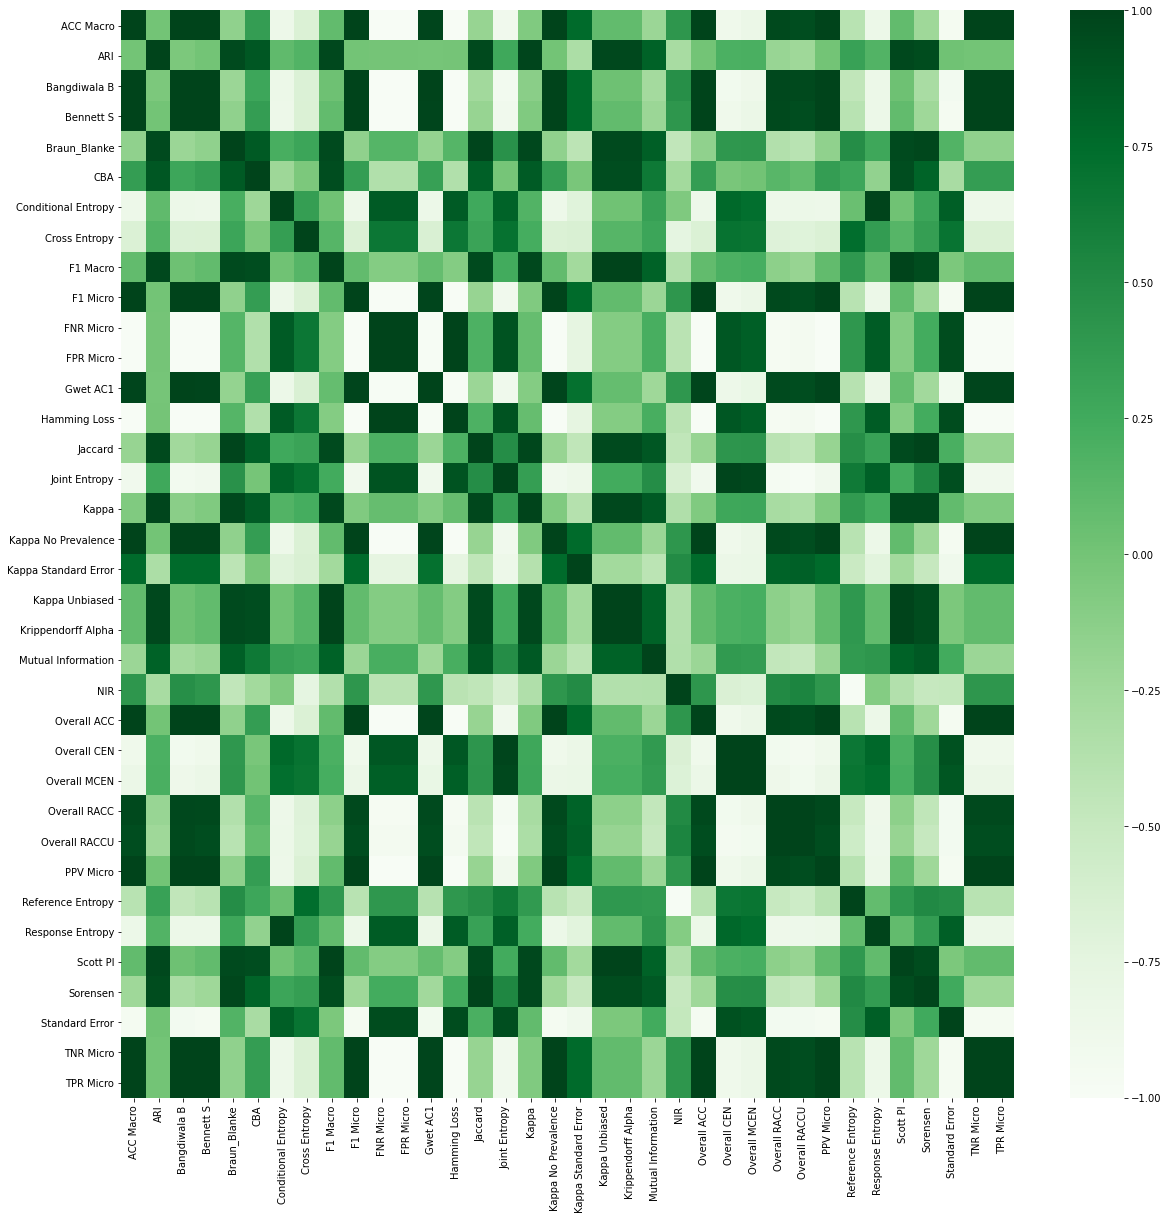

In [21]:
fig, ax = plt.subplots(1, figsize=(20,20))
sns.heatmap(corr, ax=ax, cmap="Greens")
plt.savefig("corr.png", dpi=300)
plt.show()

## Данные для всех сетей

## Учим нашу сеть

In [14]:
settings = {
    "outs" : 5,
    "input_len" : len(metrics),
    "architecture" : [11,6,5],
    "inputs" : len(metrics.columns) - 5,
    "activation" : "sigmoid",
    "gpu_name": "/gpu:1"
}

## ==== ВЫБИРАЕМ АРХИТЕКТУРУ! ====

In [20]:
%%time
history, p = lwmw.levmarq(
    settings, 
    x_train=metrics.values[:,:-5], 
    y_train=metrics.values[:,-5:], 
    mu_init=5.0, 
    min_error=8.33e-4, 
    max_steps=500, 
    mu_multiply=10, 
    mu_divide=10, 
    m_into_epoch=10, 
    verbose=True
)

=====>Training info<===== 

Settings: 
         outs:5
         input_len:60
         architecture:[11, 6, 5]
         inputs:36
         activation:sigmoid
         gpu_name:/gpu:1

tf version:  1.15.0 

shape X:	(60, 36)
shape y:	(60, 5)
      m:	60
      p:	5


Complex:
        [parameters]x[data lenth]
        544x60

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

LM step: 100, mu: 2.67e-03, current loss: 1.07e-01
LM step: 200, mu: 5.84e-04, current loss: 1.42e-02
LM step: 300, mu: 7.98e-06, current loss: 4.58e-03
LM step: 400, mu: 4.47e-04, current loss: 2.50e-03
LevMarq ended on: 415,	final loss: 7.98e-04

CPU times: user 1min 42s, sys: 1.4 s, total: 1min 44s
Wall time

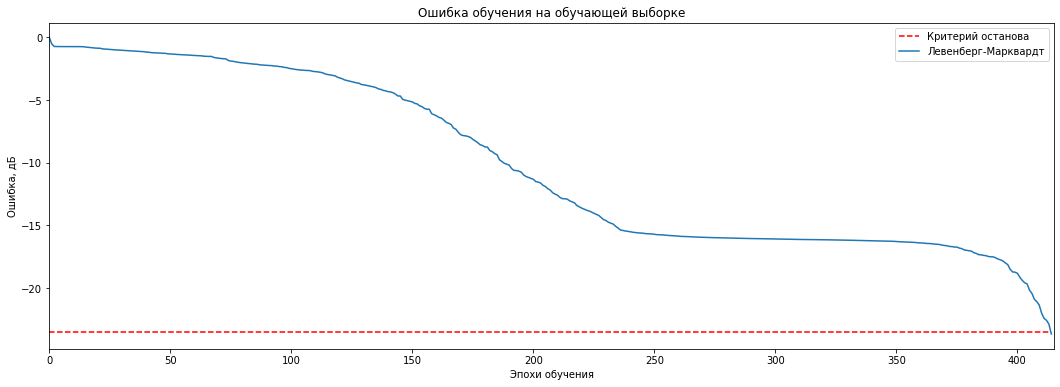

In [21]:
plt.figure(figsize=(18,6))
plt.plot([10 * np.log10(8.33e-4)] * len(history), "r--", label="Критерий останова")
plt.plot(10 * np.log10(history), label = "Левенберг-Марквардт")
plt.xlabel("Эпохи обучения")
plt.ylabel("Ошибка, дБ")
plt.xlim([0,len(history)])
plt.title(f"Ошибка обучения на обучающей выборке")
plt.legend(loc='upper right')
plt.show()

### Переинициализации

In [26]:
with open('/home/gpu/lab/medical_research/arch_dump/many_hist.pickle', 'rb') as f:
    hist_many = pickle.load(f)

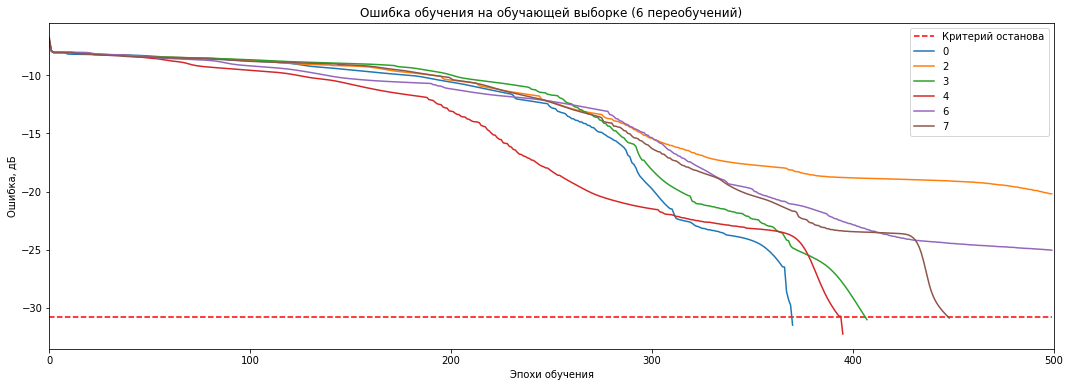

In [37]:
plt.figure(figsize=(18,6))
plt.plot([10 * np.log10(8.33e-4)] * 500, "r--", label="Критерий останова")
for hist in hist_many.keys():
    plt.plot(10 * np.log10(hist_many[hist]), label=hist)
plt.xlabel("Эпохи обучения")
plt.ylabel("Ошибка, дБ")
plt.xlim([0,500])
plt.title(f"Ошибка обучения на обучающей выборке (6 переобучений)")
plt.legend(loc="upper right")
plt.show()

## Аналитика по градиентам

In [12]:
with open('/home/gpu/lab/medical_research/arch_dump/p_many.pickle', 'rb') as f:
    p_many = pickle.load(f)
p = p_many[4]
del p_many

In [15]:
predicts, grads = lwmw.predict(p, settings, metrics.values[:,:-5])

In [16]:
for i in range(0, settings["outs"]):
    metrics["preds_" + str(i+1)] = predicts[:,i]
    metrics["delta_" + str(i)] = metrics["mark_" + str(i+1)] - metrics["preds_" + str(i+1)]

In [17]:
grads_to_plot = np.sqrt(np.sum(grads[0]**2, axis=0) / len(grads[0])) / np.sqrt(np.sum(grads[0]**2, axis=0) / len(grads[0])).max()

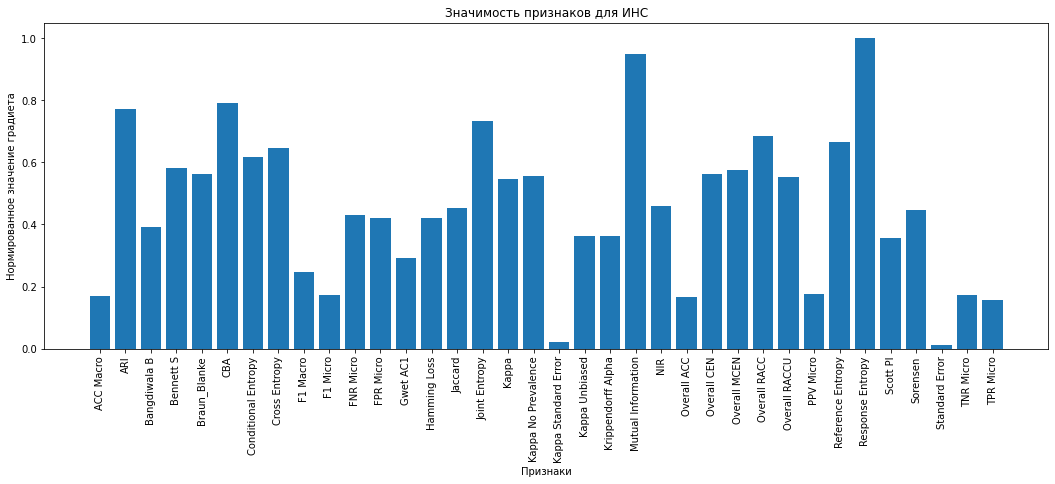

In [15]:
plt.figure(figsize=(18,6))
plt.bar(metrics.columns[:settings["inputs"]], grads_to_plot)
plt.xlabel("Признаки")
plt.ylabel("Нормированное значение градиета")
plt.title(f"Значимость признаков для ИНС")
plt.xticks(rotation=90)
plt.show()

## Сырые данные в l1 меру

In [24]:
10 * np.log10(8.33e-4)

-30.793549985932124

In [18]:
predictions = np.argmax(metrics[["preds_1", "preds_2", "preds_3", "preds_4", "preds_5"]].values, axis=1) + 1
expert_mark = np.argmax(metrics[["mark_1", "mark_2", "mark_3", "mark_4", "mark_5"]].values, axis=1) + 1

In [21]:
err = 0
for i in range(len(predictions)):
    err += np.abs(expert_mark[i] - predictions[i])
    
err = err / len(predictions)    
print(f"MAE: {err}")

MAE: 0.0


## Тест на другой сети

## Тест на метрики

In [29]:
for met in metrics.columns[:36]:
    err = 0
    for i in range(len(predictions)):
        err += np.abs((expert_mark[i] / 5) - metrics[met].values[i])
    err = err / len(predictions)
    print(f"Ошибка для '{met}': {err}")

Ошибка для 'ACC Macro': 0.2829319413503011
Ошибка для 'ARI': 0.5716489002784308
Ошибка для 'Bangdiwala B': 0.28106576301789205
Ошибка для 'Bennett S': 0.2556212425231934
Ошибка для 'Braun_Blanke': 0.546624951377333
Ошибка для 'CBA': 0.25353446658983414
Ошибка для 'Conditional Entropy': 0.37540591560037095
Ошибка для 'Cross Entropy': 0.36133998519584426
Ошибка для 'F1 Macro': 0.24143194546506022
Ошибка для 'F1 Micro': 0.2829319413503011
Ошибка для 'FNR Micro': 0.5239864953358969
Ошибка для 'FPR Micro': 0.5239864953358969
Ошибка для 'Gwet AC1': 0.2790875198444185
Ошибка для 'Hamming Loss': 0.5239864953358969
Ошибка для 'Jaccard': 0.5692561314576315
Ошибка для 'Joint Entropy': 0.3422335403540213
Ошибка для 'Kappa': 0.5578349718300974
Ошибка для 'Kappa No Prevalence': 0.2556212425231934
Ошибка для 'Kappa Standard Error': 0.6449465204104636
Ошибка для 'Kappa Unbiased': 0.5864931738356205
Ошибка для 'Krippendorff Alpha': 0.5864930286927729
Ошибка для 'Mutual Information': 0.6328662495493571
